In [20]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 加载预训练的 ResNet18 模型
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.eval()
print("-------GradCAM----------")

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.activation = None
        self.hook_handles = []

        # 注册前向传播和反向传播的钩子
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activation = output

        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0]

        # 注册钩子
        target_layer = self._get_target_layer()
        self.hook_handles.append(target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(target_layer.register_backward_hook(backward_hook))

    def _get_target_layer(self):
        # 获取目标层
        if isinstance(self.target_layer, str):
            for name, module in self.model.named_modules():
                if name == self.target_layer:
                    return module
        elif isinstance(self.target_layer, nn.Module):
            return self.target_layer
        else:
            raise ValueError("Invalid target layer type")

    def generate_cam(self, input_tensor, target_class):
        # 前向传播
        output = self.model(input_tensor)
        self.model.zero_grad()

        # 计算目标类别的梯度
        target = output[0, target_class]
        target.backward()

        # 计算 Grad-CAM
        gradient = self.gradient[0].cpu().data.numpy()
        activation = self.activation[0].cpu().data.numpy()

        weights = np.mean(gradient, axis=(1, 2))  # 计算权重
        cam = np.zeros(activation.shape[1:], dtype=np.float32)

        # 加权特征图
        for i, w in enumerate(weights):
            cam += w * activation[i]

        # ReLU 操作
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_tensor.shape[2:])  # 缩放到输入图像大小
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

    def remove_hooks(self):
        # 移除钩子
        for handle in self.hook_handles:
            handle.remove()


-------GradCAM----------


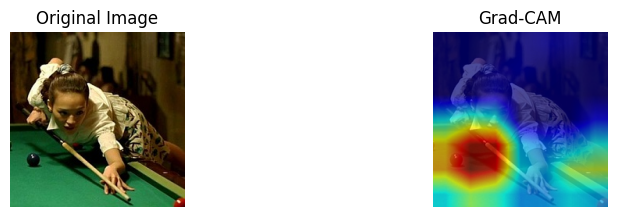

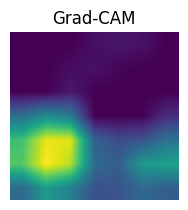

In [21]:
def load_image(image_path):
    # 打开图片
    image = Image.open(image_path).convert('RGB')
    # 定义预处理步骤
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # 对图片进行预处理
    input_tensor = preprocess(image)
    input_tensor = input_tensor.unsqueeze(0)  # 添加 batch 维度
    return input_tensor, image

# 加载图片
image_path = 'SAM/pic/suqi.jpg'  # 替换为你的图片路径
input_tensor, original_image = load_image(image_path)



# 定义目标层（ResNet18 的最后一个卷积层）
target_layer = resnet18.layer4[1].conv2

# 创建 Grad-CAM 对象
grad_cam = GradCAM(resnet18, target_layer)

# 生成热力图
target_class = 737  # 替换为你感兴趣的类别（例如：284 是 "tiger cat"）   737  是billiard table，台球桌
cam = grad_cam.generate_cam(input_tensor, target_class)

# 移除钩子
grad_cam.remove_hooks()


# 将热力图叠加到原始图片上
def overlay_cam(image, cam):
    cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    cam = cv2.resize(cam, image.size)
    cam = np.float32(cam) / 255
    overlay = np.float32(image) / 255
    overlay = cv2.addWeighted(overlay, 0.3, cam, 0.7, 0)
    return to_pil_image(overlay)

# 可视化结果
plt.figure(figsize=(10, 5))

# 显示原始图片
plt.subplot(2, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# 显示 Grad-CAM 热力图
plt.subplot(2, 2, 2)
overlay_image = overlay_cam(original_image, cam)
plt.imshow(overlay_image)
plt.title('Grad-CAM')
plt.axis('off')
plt.imsave("SAM/pic/suqi-gradcam.png",overlay_image)
plt.show()

# 显示 Grad-CAM 热力图
plt.subplot(2, 2, 3)
overlay_image = overlay_cam(original_image, cam)
plt.imshow(cam)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

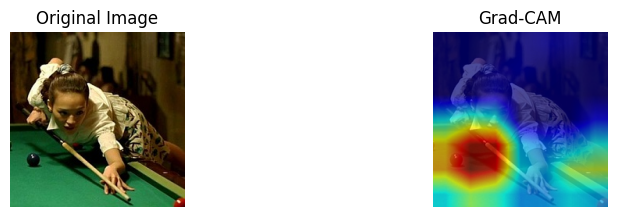

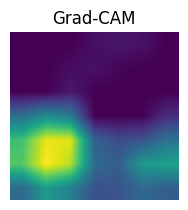